In [1]:
import pandas as pd
import os

import matplotlib.pyplot as plt

from scipy import signal

import scipy.fft as fourier
from scipy.signal.windows import hann

import numpy as np

import re

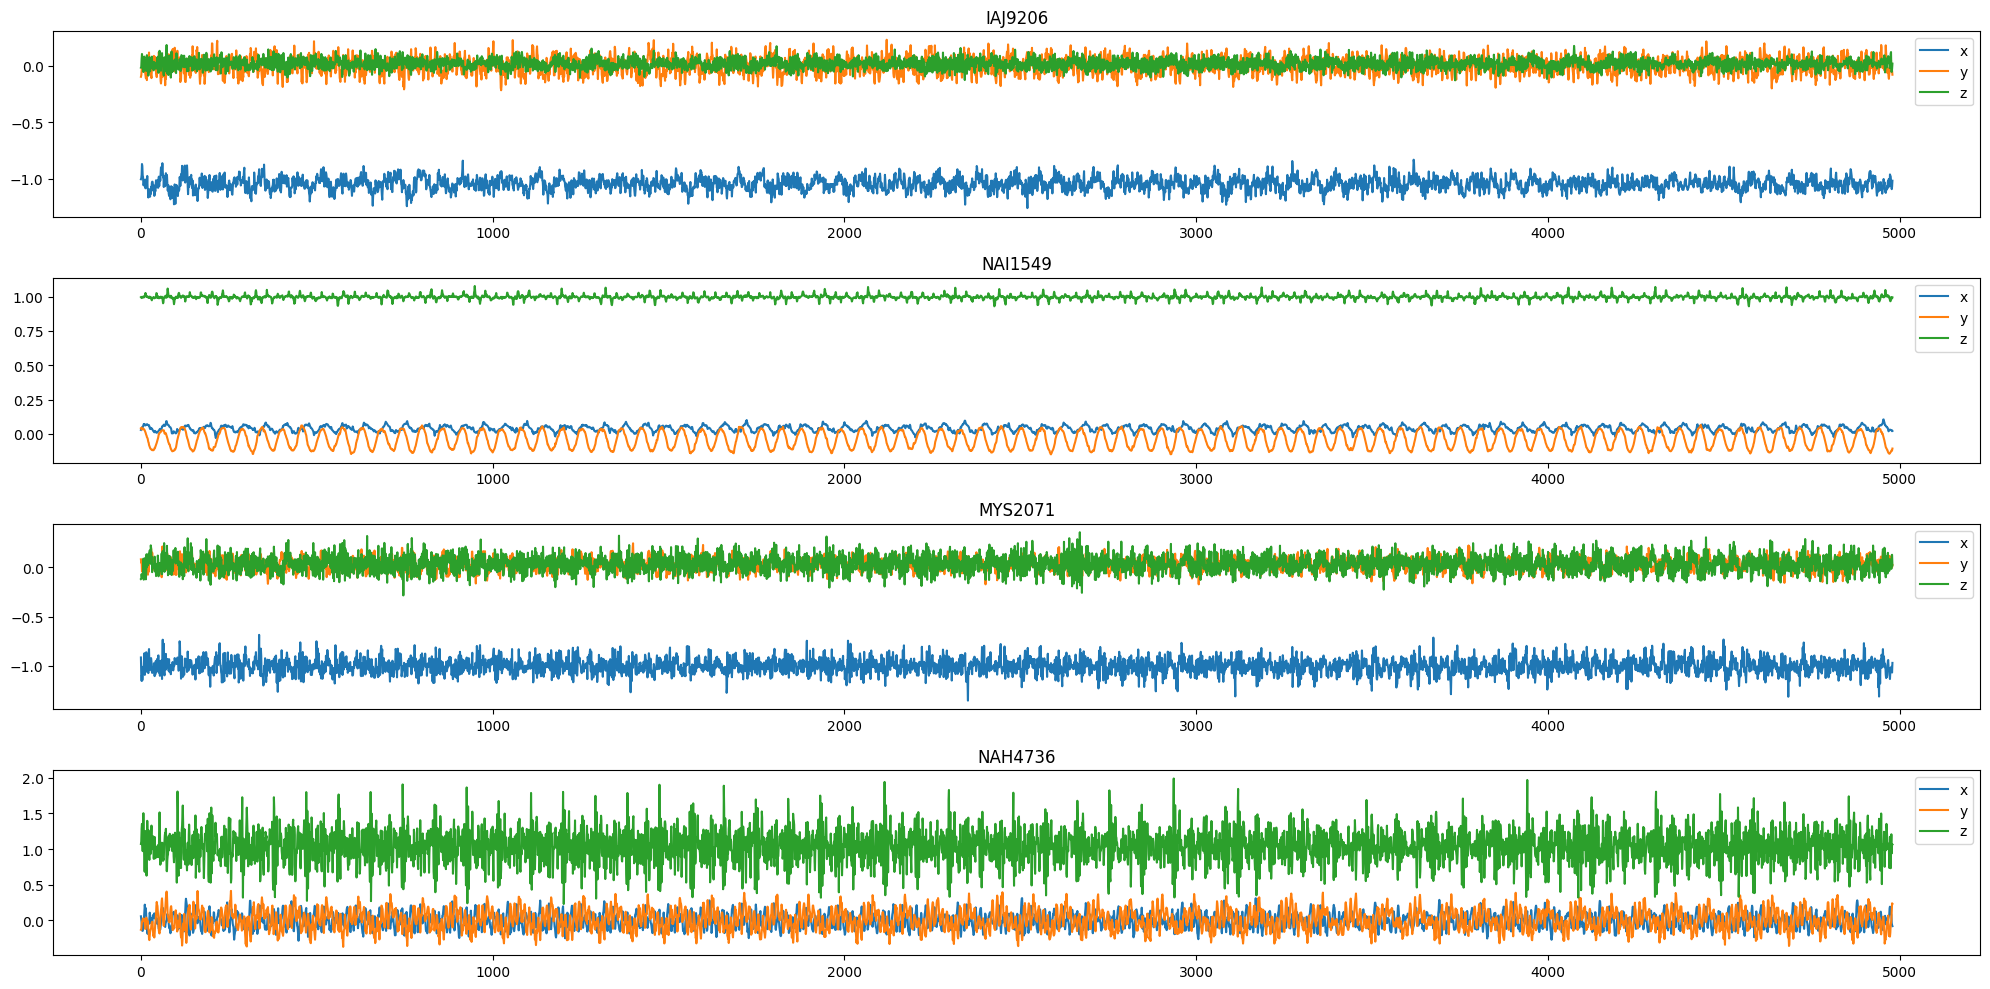

In [2]:
path = "./part_1/"
files = os.listdir(path)

#regex pattern to separate start, interval and sensor
pat = re.compile("([0-9]*)-([0-9]*)-([A-Za-z]*[0-9]*)") 
infos = [re.findall(pat,file)[0] for file in files]

fig, axs= plt.subplots(4,1,figsize=(20,10))

for i,file in enumerate(files):
    data = pd.read_csv(path+file)
    data.plot(ax=axs[i])
    axs[i].set_title(infos[i][2])

plt.tight_layout()

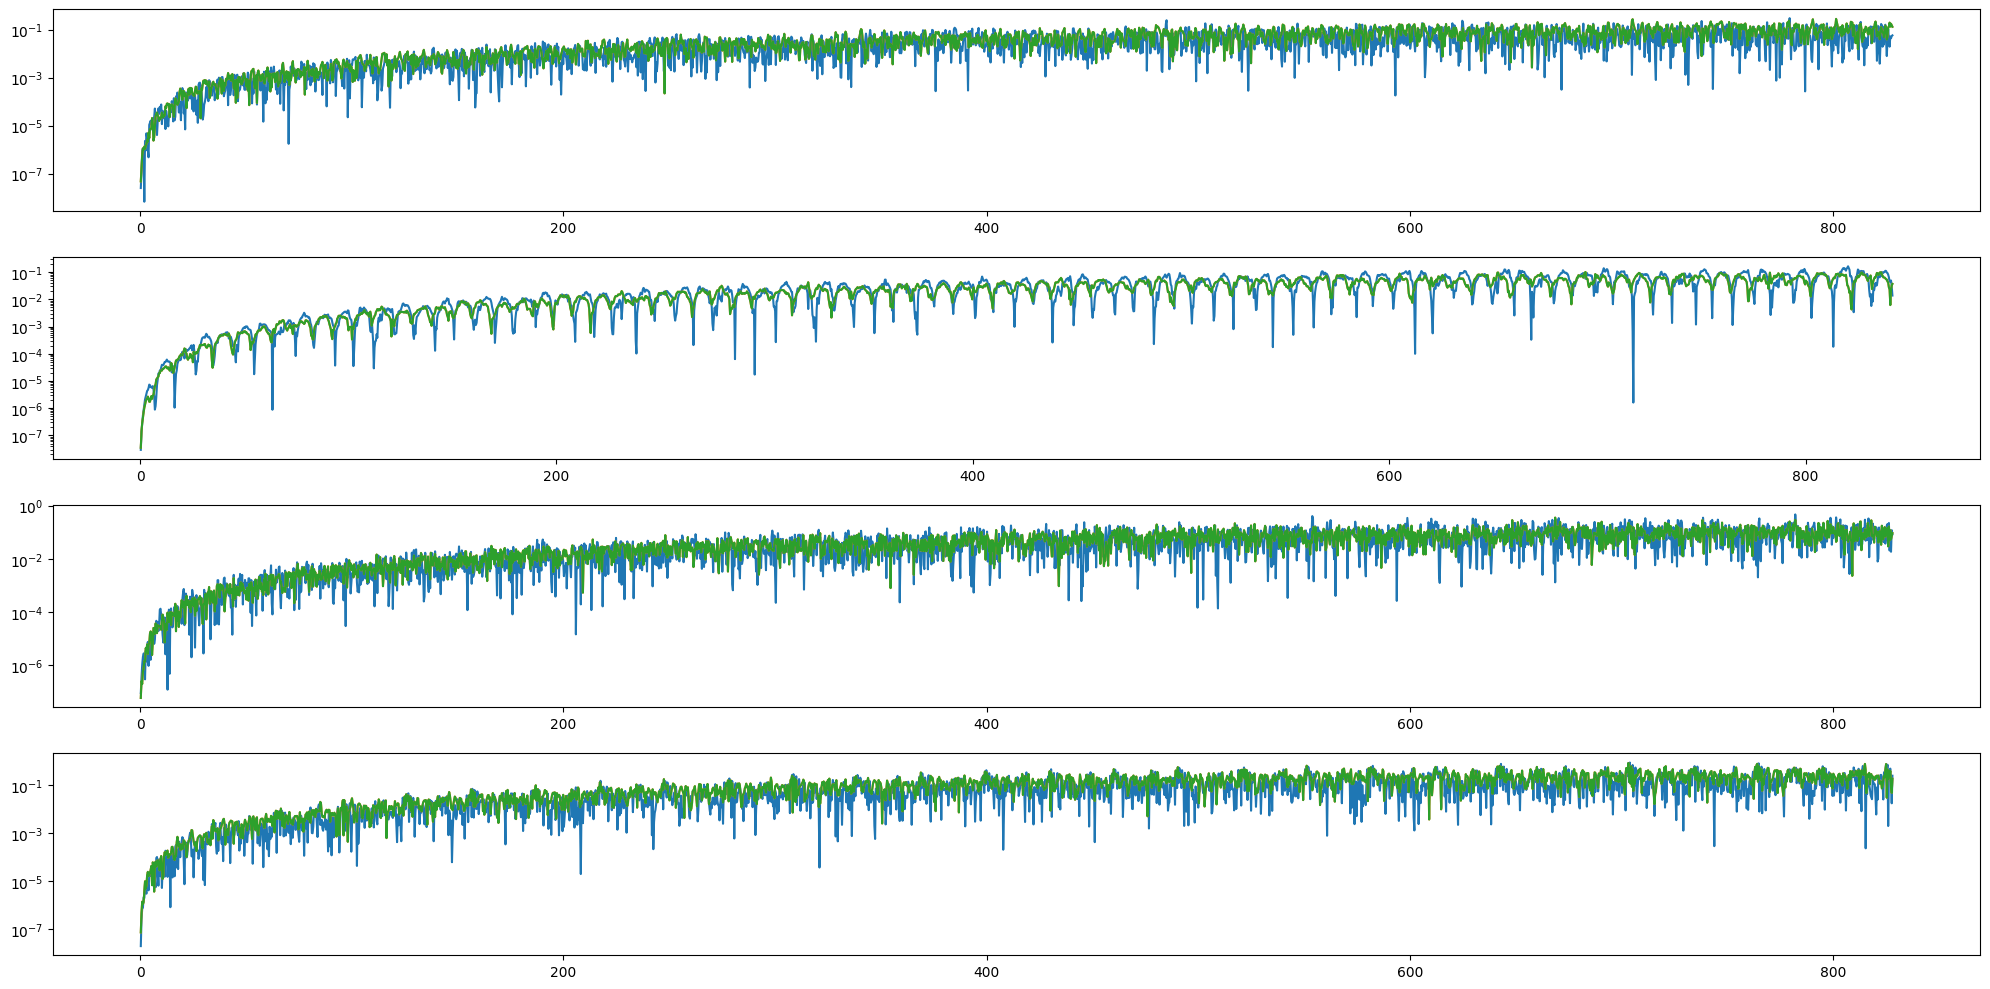

In [6]:
fig, axs= plt.subplots(4,1,figsize=(20,10))

for i,file in enumerate(files):

    data = pd.read_csv(path+files[i])

    dataCentered = data - data.mean() #centering data 

    N = data.shape[0]

    T = int(infos[i][1])/1000 #s

    window = hann(N)
    xf = fourier.fft(dataCentered.mul(window,axis=0))
    freq = fourier.fftfreq(N,d=T/N)

    absolute = np.abs(xf)

    axs[i].semilogy(freq[1:N//2],absolute[1:N//2])


plt.tight_layout()

In [ ]:
fs = N / T          # taxa de amostragem
f, Pxx = signal.welch(x, fs=fs, window='hann', nperseg=4096, noverlap=2048, scaling='density')



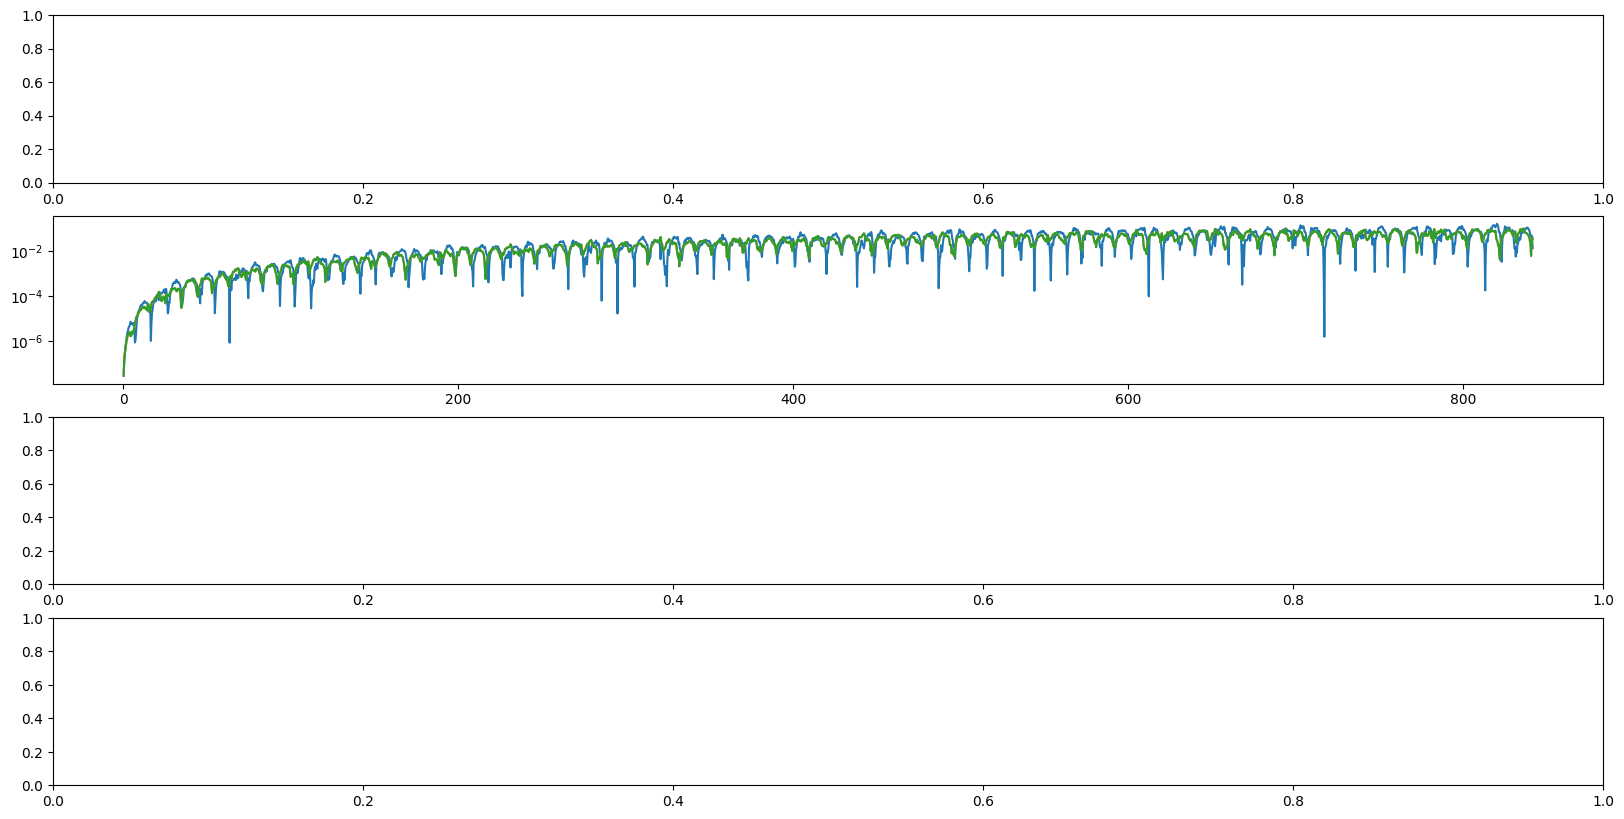

In [8]:
i = 1

data = pd.read_csv(path+files[i])

dataCentered = data - data.mean() #centering data 

N = data.shape[0]

T = int(infos[i][1])/1000 #s

window = hann(N)
xf = fourier.fft(dataCentered.mul(window,axis=0))
freq = fourier.fftfreq(N,d=T/N)

absolute = np.abs(xf)
fig, axs= plt.subplots(4,1,figsize=(20,10))
axs[i].semilogy(freq[1:N//2],absolute[1:N//2])